# Interpolation comparison using different variogram models

Earlier we saw that there are different types of variogram models with different shapes. In this script, we'll use a synthetic example to explore how the variogram model affects the interpolation. For this example, we need to use GStools (https://github.com/GeoStat-Framework/GSTools) to generate an example data set. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer 
import gstatsim as gs
import skgstat as skg
from skgstat import models
import random
import gstools as gst

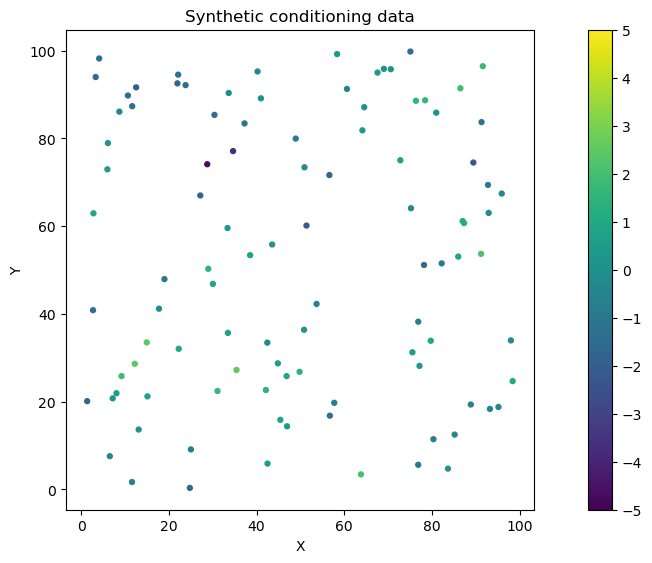

In [2]:
# create random conditioning data using GSTools
x = np.random.RandomState(100000).rand(100) * 100.
y = np.random.RandomState(200000).rand(100) * 100.
model = gst.Gaussian(dim=2, var=2, len_scale =8)
srf = gst.SRF(model, mean=0, seed=300000)
field = srf((x,y))

# plot synthetic conditioning data
fig = plt.figure()
im = plt.scatter(x,y, c = field, vmin = -5, vmax = 5, marker=".", s = 50)       # scatter plot for location map
plt.title('Synthetic conditioning data')                                    # add plot title
plt.xlabel('X'); plt.ylabel('Y')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-5, 5, 11)) # add vertical color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')
plt.show()

In [3]:
# make dataframe
data = np.transpose([x,y,field])
df = pd.DataFrame(data, columns = ['X','Y','Z'])
df.head()

,X,Y,Z
0,28.756086,74.131298,-4.624638
1,50.824819,36.393990,0.233011
2,49.804102,26.813835,1.402964
3,78.166945,51.162204,-1.575844
4,12.240347,28.640275,2.443942


In [4]:
# compute experimental variogram

coords = np.column_stack((x, y))
maxlag = 100      # maximum range distance
n_lags = 20         # num of bins

# compute variogram
V1 = skg.Variogram(coords, field, bin_func='even', n_lags=n_lags, maxlag=maxlag, normalize=False)

## Fit variogram models

In [5]:
V1.model = 'gaussian' 
V1.parameters

[22.693182021113245, 1.645157828052616, 0]

In [6]:
V2 = V1
V2.model = 'exponential' 
V2.parameters

[33.29055115996483, 1.6759340161439038, 0]

In [7]:
V3 = V1
V3.model = 'spherical' 
V3.parameters

[25.747523860000438, 1.6461667328794227, 0]

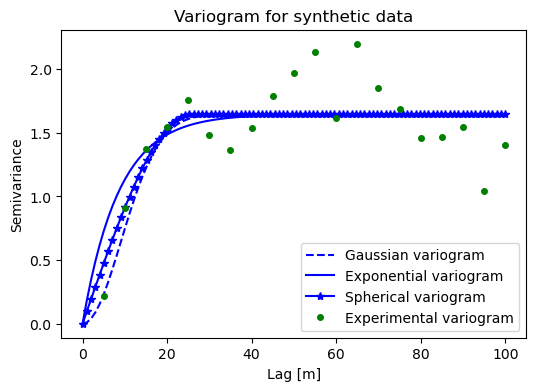

In [8]:
# plot variograms

# extract experimental variogram values
xdata = V1.bins
ydata = V1.experimental

# evaluate models
xi = np.linspace(0, xdata[-1], 100) 
y_gauss = [models.gaussian(h, V1.parameters[0], V1.parameters[1], V1.parameters[2]) for h in xi]

y_exp = [models.exponential(h, V2.parameters[0], V2.parameters[1], V2.parameters[2]) for h in xi]

y_sph = [models.spherical(h, V3.parameters[0], V3.parameters[1], V3.parameters[2]) for h in xi]

# plot variogram model
fig = plt.figure(figsize=(6,4))
plt.plot(xi, y_gauss,'b--', label='Gaussian variogram')
plt.plot(xi, y_exp,'b-', label='Exponential variogram')
plt.plot(xi, y_sph,'b*-', label='Spherical variogram')
plt.plot(xdata, ydata,'og', markersize=4, label='Experimental variogram')
plt.title('Variogram for synthetic data')
plt.xlabel('Lag [m]'); plt.ylabel('Semivariance')  
plt.legend(loc='lower right')
plt.show()

## Initialize grid

Make list of grid cells that need to be simulated.

In [9]:
# define coordinate grid
xmin = 0; xmax = 100     # min and max x values
ymin = 0; ymax = 100     # min and max y values
res = 1

Pred_grid_xy = gs.Gridding.prediction_grid(xmin, xmax, ymin, ymax, res)

## Sequential Gaussian simulation

In this example we use okrige_sgs.

In [10]:
# set variogram parameters
azimuth = 0
nugget = V1.parameters[2]

# save variogram parameters as a list
vtype = 'Gaussian'
vario1 = [azimuth, V1.parameters[2], V1.parameters[0], V1.parameters[0], V1.parameters[1], vtype]

vtype = 'Exponential'
vario2 = [azimuth, V2.parameters[2], V2.parameters[0], V2.parameters[0], V2.parameters[1], vtype]

vtype = 'Spherical'
vario3 = [azimuth, V3.parameters[2], V3.parameters[0], V3.parameters[0], V3.parameters[1], vtype]

k = 48      # number of neighboring data points used to estimate a given point 
rad = 50    # search radius

In [11]:
# simulation

sim_gauss = gs.Interpolation.okrige_sgs(Pred_grid_xy, df, 'X', 'Y', 'Z', k, vario1, rad) 

sim_exp = gs.Interpolation.okrige_sgs(Pred_grid_xy, df, 'X', 'Y', 'Z', k, vario2, rad) 

sim_sph = gs.Interpolation.okrige_sgs(Pred_grid_xy, df, 'X', 'Y', 'Z', k, vario3, rad) 

100%|████████████████████████████████████| 10201/10201 [00:40<00:00, 251.61it/s]


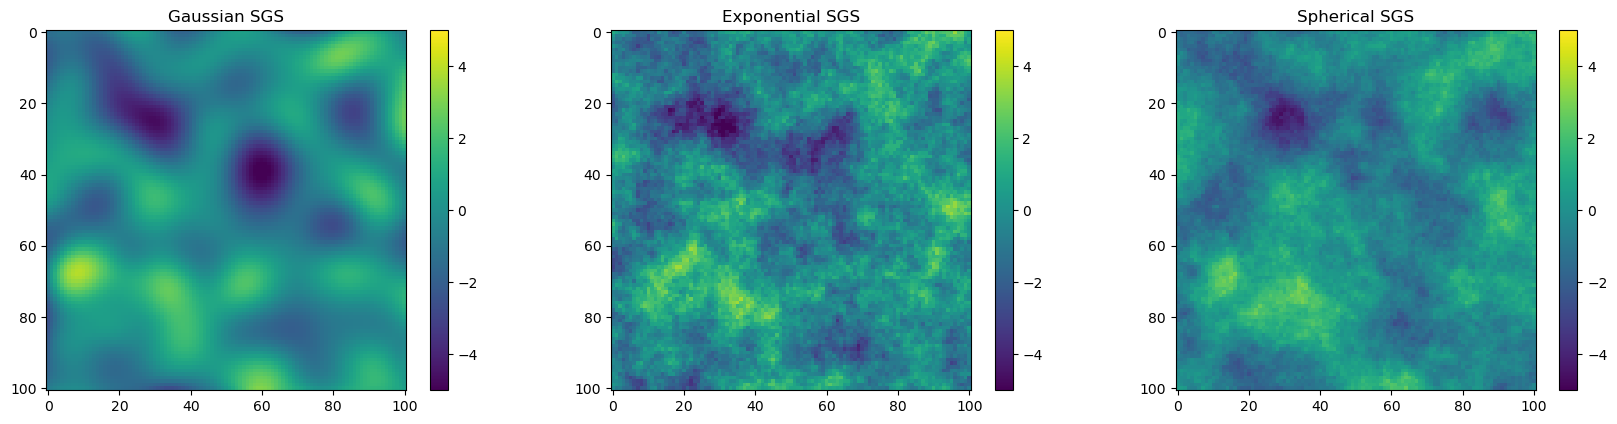

In [12]:
vmax = 5
vmin = -vmax

fig = plt.figure()
plt.subplot(131)
im = plt.imshow(sim_gauss.reshape(101,101), vmin = vmin, vmax = vmax)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top=.75) # adjust the plot size
plt.colorbar()
plt.title('Gaussian SGS')

plt.subplot(132)
im = plt.imshow(sim_exp.reshape(101,101), vmin = vmin, vmax = vmax)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top=.75) # adjust the plot size
plt.colorbar()
plt.title('Exponential SGS')

plt.subplot(133)
im = plt.imshow(sim_sph.reshape(101,101), vmin = vmin, vmax = vmax) 
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top=.75) # adjust the plot size
plt.colorbar()
plt.title('Spherical SGS')
plt.show()

Here we can see that SGS with different variogram models has different spatial characteristics. For example, the Gaussian SGS realization is very smooth because the Gaussian variogram model is nearly zero at small lags. 

In [13]:
# kriging
krige_gauss, var_gauss = gs.Interpolation.okrige(Pred_grid_xy, df, 'X', 'Y', 'Z', k, vario1, rad) 

krige_exp, var_exp = gs.Interpolation.okrige(Pred_grid_xy, df, 'X', 'Y', 'Z', k, vario2, rad) 

krige_sph, var_sph = gs.Interpolation.okrige(Pred_grid_xy, df, 'X', 'Y', 'Z', k, vario3, rad) 

100%|████████████████████████████████████| 10201/10201 [00:33<00:00, 301.57it/s]


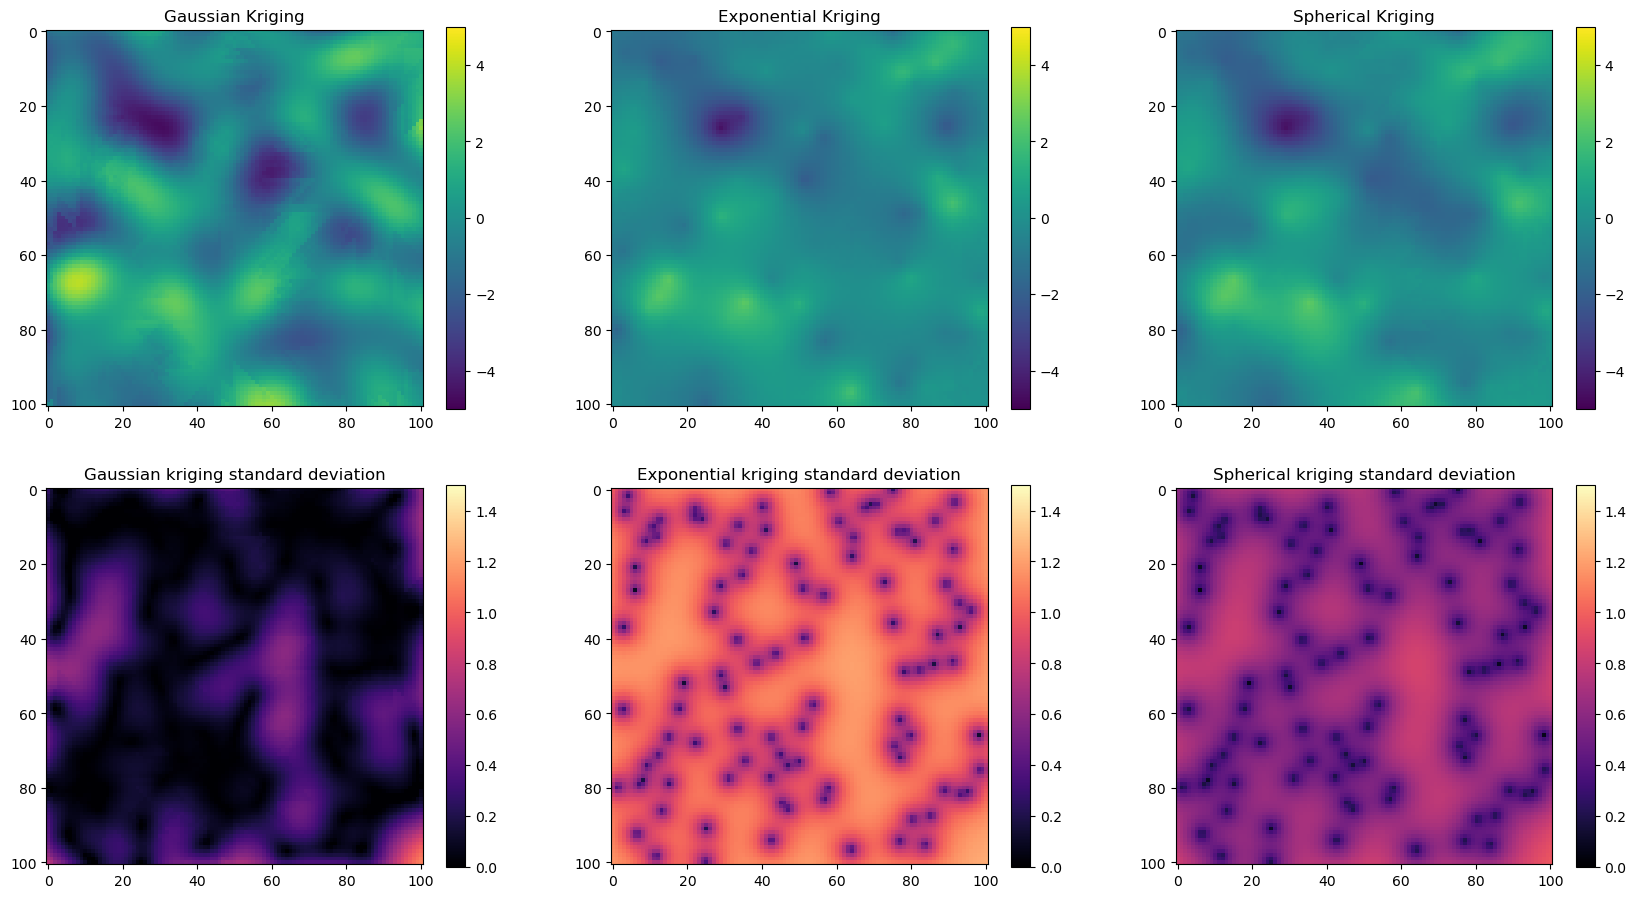

In [14]:
# kriging plots
vmax = 5
vmin = -vmax

fig = plt.figure()
plt.subplot(231)
im = plt.imshow(krige_gauss.reshape(101,101), vmin = vmin, vmax = vmax)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top=.75) # adjust the plot size
plt.colorbar()
plt.title('Gaussian Kriging')

plt.subplot(232)
im = plt.imshow(krige_exp.reshape(101,101), vmin = vmin, vmax = vmax)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top=.75) # adjust the plot size
plt.colorbar()
plt.title('Exponential Kriging')

plt.subplot(233)
im = plt.imshow(krige_sph.reshape(101,101), vmin = vmin, vmax = vmax)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top=.75) # adjust the plot size
plt.colorbar()
plt.title('Spherical Kriging')

plt.subplot(234)
im = plt.imshow(np.sqrt(var_gauss.reshape(101,101)), vmin = 0, vmax = 1.5, cmap = 'magma')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top=.75) # adjust the plot size
plt.colorbar()
plt.title('Gaussian kriging standard deviation')

plt.subplot(235)
im = plt.imshow(np.sqrt(var_exp.reshape(101,101)), vmin = 0, vmax = 1.5, cmap = 'magma')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top=.75) # adjust the plot size
plt.colorbar()
plt.title('Exponential kriging standard deviation')

plt.subplot(236)
im = plt.imshow(np.sqrt(var_sph.reshape(101,101)), vmin = 0, vmax = 1.5, cmap = 'magma')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top=1.75) # adjust the plot size
plt.colorbar()
plt.title('Spherical kriging standard deviation')
plt.show()

The different kriging results are fairly similar, but the uncertainties are much lower for the Gaussian model and greater for the Exponential model. So using the wrong variogram model type could cause you to overestimate or underestimate the uncertainty.

To choose the right variogram model, you can compare the different variogram models to the experimental variogram to see which one fits best. In some cases, the best choice might be unclear. It is also important to consider the geological phenomena you are modeling and the type of spatial structure it has. For example, if you are modeling a geological condition that you know is smoothly varying, then you would most likely want to use a Gaussian variogram.

Download the tutorial {Download}`here<./5_Variogram_interpolation_comparison.ipynb>`.